# Synthesize 

Take the parsed, cleaned data, and synthesize a long-term daily record for the constituents
currently going into the model.

Specifically, this means
 - 2000 - 2016
 - NOx, NH3, OrthoP
 - False Delta sources, plus the 40+ discharges in the Bay.

In [1]:
from __future__ import print_function
import six
import pandas as pd

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import utils
import lp_filter
import glob
import os
%matplotlib notebook 

/Users/rusty/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
from ipywidgets import interactive

In [53]:
compile_dir="../outputs/intermediate"
output_dir="../outputs"

In [36]:
date_start=datetime.datetime(2000,1,1)
date_end  =datetime.datetime(2015,12,31)

dn_start=utils.to_dnum(date_start)
dn_end  =utils.to_dnum(date_end)

dns=np.arange(dn_start,dn_end+1)
fmt='%Y-%m-%d'
print("Generating daily data from %s to %s for %d time points"%(date_start.strftime(fmt),
                                                                date_end.strftime(fmt),
                                                                len(dns)))
ds=xr.Dataset()
ds['time']=utils.to_dt64(dns)
ds['dnum']=('time',dns)
ds=ds.set_coords('dnum')

analytes=['flow',
          'NOx_conc','NH3_conc','PO4_conc','Si_conc',
          'NOx_load','NH3_load','PO4_load','Si_load']

# These match the names of the CSV files
site_names=['tesoro','american','sasm','novato','sunnyvale',
            'petaluma','rodeo','fs','valero','phillips66',
            'vallejo','ebmud','san_mateo','sfo','palo_alto','sausalito',
            'south_bayside','ddsd','burlingame','pinole','st_helena',
            'yountville','benicia','millbrae','sonoma_valley','napa',
            'cccsd','ebda','calistoga','central_marin','lg','west_county_richmond',
            'chevron','sf_southeast','shell','mt_view','marin5','san_jose',
            'south_sf','ch','treasure_island','false_sj','false_sac' ]
ds['site']=( 'site', site_names)

# initialize full output array

for analyte in analytes:
    ds[analyte]=( ['time','site'],
             np.nan*np.ones( (len(ds.time),len(ds.site)) ) )

# set units for clarity upfront
ds.flow.attrs['units']='m3 s-1'

ds.NOx_conc.attrs['units']='mg/l N'
ds.NH3_conc.attrs['units']='mg/l N'
ds.PO4_conc.attrs['units']='mg/l P'
ds.Si_conc.attrs['units']='mg/l Si'
ds.NOx_load.attrs['units']='kg/day N'
ds.NH3_load.attrs['units']='kg/day N'
ds.PO4_load.attrs['units']='kg/day P'
ds.Si_load.attrs['units']='kg/day Si'

# setup flag entries
for v in ds.data_vars.keys():
    ds[v+'_flag']=( ds[v].dims, np.zeros(ds[v].shape,'i2'))
    ds[v].attrs['flags']=v+'_flag'

Generating daily data from 2000-01-01 to 2015-12-31 for 5844 time points


In [37]:
ds

<xarray.Dataset>
Dimensions:        (site: 43, time: 5844)
Coordinates:
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
    dnum           (time) float64 7.301e+05 7.301e+05 7.301e+05 7.301e+05 ...
  * site           (site) |S20 'tesoro' 'american' 'sasm' 'novato' ...
Data variables:
    flow           (time, site) float64 nan nan nan nan nan nan nan nan nan ...
    NOx_conc       (time, site) float64 nan nan nan nan nan nan nan nan nan ...
    NH3_conc       (time, site) float64 nan nan nan nan nan nan nan nan nan ...
    PO4_conc       (time, site) float64 nan nan nan nan nan nan nan nan nan ...
    Si_conc        (time, site) float64 nan nan nan nan nan nan nan nan nan ...
    NOx_load       (time, site) float64 nan nan nan nan nan nan nan nan nan ...
    NH3_load       (time, site) float64 nan nan nan nan nan nan nan nan nan ...
    PO4_load       (time, site) float64 nan nan nan nan nan nan nan nan nan ...
    Si_load        (time, site) float64 nan n

In [38]:
FLAG_LOADING_STUDY=1
FLAG_HDR=2
FLAG_SUMMER_ZERO=4
FLAG_SEASONAL_TREND=8
FLAG_INTERP=16
FLAG_MEAN=32

In [39]:
for site in ds.site: 
    site=site.item() # get to a str object
    site_idx=list(ds.site).index(site) # 11

    csv=pd.read_csv(os.path.join(compile_dir,site+'.csv'),
                        parse_dates=['Date'])
    csv_dnums=utils.to_dnum(csv.Date)
    csv_date_i = np.searchsorted(dns,csv_dnums)
 
    # limit to the overlap between csv dates and output dates
    date_valid=(csv_dnums>=dns[0]) & (csv_dnums<dns[-1])

    if 1: # FLOW
        if 'flow ft3/s' in csv:
            flow=0.028316847 * csv['flow ft3/s']
        elif 'flow mgd' in csv:
            flow=0.043812636 * csv['flow mgd']
        else:
            assert False
        valid=date_valid & ( ~flow.isnull().values)
        ds['flow'].isel(site=site_idx)[csv_date_i[valid]] = flow[valid]
        ds['flow_flag'].isel(site=site_idx)[csv_date_i[valid]]=FLAG_LOADING_STUDY
    
    if 1: # NOx:
        nox=csv['NO3 mg/L N'].copy()
        try:
            nox += csv['NO2 mg/L N']
        except KeyError:
            print("No NO2 for %s - okay"%site)
        valid=date_valid & (~nox.isnull().values)

        ds['NOx_conc'].isel(site=site_idx)[csv_date_i[valid]]=nox[valid]
        ds['NOx_conc_flag'].isel(site=site_idx)[csv_date_i[valid]]=FLAG_LOADING_STUDY
        
    if 1: # NH3
        nh3=csv['NH3 mg/L N']
        valid=date_valid & (~nh3.isnull().values)

        ds['NH3_conc'].isel(site=site_idx)[csv_date_i[valid]]=nh3[valid]
        ds['NH3_conc_flag'].isel(site=site_idx)[csv_date_i[valid]]=FLAG_LOADING_STUDY
        
    if 1: # PO4
        po4=csv['PO4 mg/L P']
        valid=date_valid & (~po4.isnull().values)

        ds['PO4_conc'].isel(site=site_idx)[csv_date_i[valid]]=po4[valid]
        ds['PO4_conc_flag'].isel(site=site_idx)[csv_date_i[valid]]=FLAG_LOADING_STUDY

No NO2 for false_sj - okay
No NO2 for false_sac - okay


In [40]:

def bin_mean(bins,values):
    sums=np.bincount(bins,weights=values)
    counts=np.bincount(bins)
    return sums/counts


def mark_gaps(dnums,valid,gap_days,yearday_start=-1,yearday_end=367):
    # for a timeseries, assumed to be dense, daily
    # return a mask which is true for gaps in valid data
    # which span at least gap_days, limited to the portion of 
    # the year given by yearday_start,yearday_end
    doy=np.array([d - utils.dnum_jday0(d)
                  for d in dnums] )

    missing=~valid
    in_window=(doy>=yearday_start)&(doy<yearday_end)
    present=np.nonzero( ~missing | ~in_window)[0]

    mask=np.zeros( len(dnums),np.bool )

    for gstart,gend in zip( present[:-1],present[1:] ):
        if gend-gstart<gap_days:
            continue
        mask[ gstart+gap_days//2 : gend-gap_days//2 ] = True
    return mask
    
def add_summer_noflow(site,gap_days=45,day_start=100,day_end=305):
    """ Designed for Napa, but possibly extend to others.
    Gaps of more than gap_days, which fall within the period
    dayofyear between [day_start,day_end] are filled with zero 
    flow.
    """
    gap_mask = mark_gaps(dns, 
                         np.isfinite( ds['flow'].sel(site=site).values ),
                         gap_days=gap_days,
                         yearday_start=day_start,
                         yearday_end=day_end)
    ds.flow.sel(site=site).values[gap_mask] = 0
    ds.flow_flag.sel(site=site).values[gap_mask] = FLAG_SUMMER_ZERO

# special handling of Napa with typically no flow in summer
add_summer_noflow(site='napa',gap_days=45,day_start=100,day_end=305)


In [41]:
# Load the HDR data in long format
hdr_fn=os.path.join(compile_dir,'hdr_parsed_long.csv')
hdr=pd.read_csv(hdr_fn)
month_starts=[ datetime.datetime(year=int(r.year),month=int(r.month),day=1)
               for ri,r in hdr.iterrows()]
hdr['dn_start']=utils.to_dnum( np.array(month_starts))
hdr.head()

,analyte,year,month,site,value,dn_start
0,flow_mgd,2012,7.0,San Pablo Bay,15.989105,734685.0
1,flow_mgd,2012,8.0,San Pablo Bay,15.852014,734716.0
2,flow_mgd,2012,9.0,San Pablo Bay,15.340764,734747.0
3,flow_mgd,2012,10.0,San Pablo Bay,21.317394,734777.0
4,flow_mgd,2012,11.0,San Pablo Bay,48.396282,734808.0


In [42]:
# bring in HDR data
sites=hdr.site.unique()
site_map=dict(zip(sites,[s.lower() for s in sites]))

In [43]:
site_map['American Canyon']='american'
site_map['CMSA']='central_marin'
site_map['Delta Diablo']='ddsd'
site_map['Fairfield-Suisun']='fs'
site_map['Las Gallinas']='lg'
site_map['Mt View']='mt_view'
site_map['Palo Alto']='palo_alto'
site_map['San Jose/Santa Clara']='san_jose'
site_map['San Mateo']='san_mateo'
site_map['SFO Airport']='sfo'
site_map['SFPUC Southeast Plant']='sf_southeast'
site_map['Sonoma Valley']='sonoma_valley'
site_map['South SF']='south_sf'
site_map['Treasure Island']='treasure_island'
site_map['West County']='west_county_richmond'
site_map['SVCW']='south_bayside' # silicon valley clean water - new name for south_bayside
site_map['SMCSD']= 'sausalito' # 
site_map['Crockett CSD Port Costa'] = 'ch' # right?

# These are in the HDR data, but not loading study:
# site_map['Tiburon'] = ?
site_map['Paradise Cove']= 'marin5'# but Tiburon is also Marin SD 5...

# These are in the Loading study, but not HDR:
# refineries: tesoro, valero, phillips66, chevron, shell
# potws: st_helena, yountville, calistoga - all up Napa, right?
# false: false_sj, false_sac

for site in ds.site:
    site=site.item()
    if site not in site_map.values():
        print("Site not in map: %s"%site)

Site not in map: tesoro
Site not in map: valero
Site not in map: phillips66
Site not in map: st_helena
Site not in map: yountville
Site not in map: calistoga
Site not in map: chevron
Site not in map: shell
Site not in map: false_sj
Site not in map: false_sac


In [44]:
for hdr_name,ls_name in six.iteritems(site_map):
    if ls_name not in list(ds.site.values):
        continue
    print( "%s => %s"%(hdr_name,ls_name))
    hdr_site = hdr[ hdr.site==hdr_name ]

    # move the analytes back to columns
    hdr_site = hdr_site.pivot(index='dn_start',columns='analyte',values='value').reset_index()
    dn_end=np.zeros(len(hdr_site.dn_start.values),'f8')
    dn_end[:-1]=hdr_site.dn_start.values[1:]
    dn_end[-1] = hdr_site.dn_start.values[-1] + 31
    hdr_site['dn_end']=dn_end
    hdr_site.head()

    for ri,r in hdr_site.iterrows():
        time_slc=slice(*np.searchsorted(ds.dnum,[r.dn_start,r.dn_end]))

        ds_site = ds.sel(site=site_map[hdr_name])

        def from_hdr(ds_fld,hdr_fld,factor=1):    
            ds_site[ds_fld].values[time_slc] = r[hdr_fld] * factor
            ds_site[ds_fld+'_flag'].values[time_slc] = FLAG_HDR

        # overwrite with HDR data, constant over month

        from_hdr('flow','flow_mgd',0.043812636)
        from_hdr('NOx_load','NOx_kgN_per_day',1)
        from_hdr('NH3_load','ammonia_kgN_per_day',1)
        # unclear whether we should go with diss_OrthoP, or total_kgP ...
        from_hdr('PO4_load','diss_OrthoP_kgP_per_day')

        # and the conversion to conc:
        def to_conc(ds_fld):
            flow = ds_site['flow'].values[time_slc] # m3/s
            load = ds_site[ds_fld+'_load'].values[time_slc] # kg X / day
            # convert to g/m3
            conc = (load * 1000) / (flow*86400)
            conc[ flow==0.0] = 0.0
            #    (kgX/d) * g/kg / (m3/s * s/day) => gX / m3
            ds_site[ds_fld+'_conc'].values[time_slc] = conc
            ds_site[ds_fld+'_conc_flag'].values[time_slc] = FLAG_HDR

        to_conc('NOx')
        to_conc('NH3')
        to_conc('PO4')


Millbrae => millbrae
Novato => novato
CCCSD => cccsd
South SF => south_sf
American Canyon => american
Napa => napa
San Mateo => san_mateo
Benicia => benicia
Burlingame => burlingame
Treasure Island => treasure_island
SMCSD => sausalito
EBDA => ebda
Mt View => mt_view
San Jose/Santa Clara => san_jose
Fairfield-Suisun => fs
SASM => sasm
SVCW => south_bayside
SFPUC Southeast Plant => sf_southeast
EBMUD => ebmud
Vallejo => vallejo
Crockett CSD Port Costa => ch
Las Gallinas => lg
Delta Diablo => ddsd
SFO Airport => sfo
Rodeo => rodeo
Petaluma => petaluma
Sunnyvale => sunnyvale
Palo Alto => palo_alto
CMSA => central_marin
Paradise Cove => marin5
West County => west_county_richmond
Pinole => pinole
Sonoma Valley => sonoma_valley


In [45]:
fld

'dnum'

In [46]:
# The interpolation step - building off of synth_v02.py
site='ebmud' # for testing
fld='flow'

fields=[s for s in ds.data_vars if not s.endswith('_flag')]

for site in ds.site.values:
    for fld in fields: 
        fld_in=ds[fld].sel(site=site)
        orig_values=fld_in.values
        fld_flag=ds[fld+'_flag'].sel(site=site)

        n_valid=np.sum( ~fld_in.isnull())
        print("Site: %s  field: %s  %d/%d valid input points"%(site,fld,n_valid,len(fld_in)))

        if n_valid==0:
            print("--SKIPPING--")
            continue
            
        # get the data into a monthly time series before trying to fit seasonal cycle
        # first, create mapping from time index to absolute month
        dts=utils.to_datetime(dns)
        absmonth = [12*dt.year + (dt.month-1) for dt in dts]
        absmonth = np.array(absmonth) - dts[0].year*12
        month=absmonth%12

        valid = np.isfinite(fld_in.values)
        absmonth_mean=bin_mean(absmonth[valid],fld_in.values[valid])
        month_mean=bin_mean(month[valid],fld_in.values[valid])
        
        if np.sum(np.isfinite(month_mean)) < 12:
            print("Insufficient data for seasonal trends - will fill with sample mean")
            trend_and_season=np.nanmean(month_mean) * np.ones(len(dns))
            t_and_s_flag=FLAG_MEAN
        else:
            # fit long-term trend and a stationary seasonal cycle
            # this removes both the seasonal cycle and the long-term mean,
            # leaving just the trend
            trend_hf=fld_in.values - month_mean[month]
            lp = lp_filter.lowpass_fir(trend_hf,3*365)
            trend = utils.fill_invalid(lp)
            # recombine with the long-term mean and monthly trend 
            # to get the fill values.
            trend_and_season = trend + month_mean[month]
            t_and_s_flag=FLAG_SEASONAL_TREND

        # long gaps are mostly filled by trend and season
        gaps=mark_gaps(dns,valid,10) # gaps more than 10 days
        fld_in.values[gaps] = trend_and_season[gaps]
        fld_flag.values[gaps] = t_and_s_flag

        still_missing=np.isnan(fld_in.values)
        fld_in.values[still_missing] = utils.fill_invalid(fld_in.values)[still_missing]
        fld_flag.values[still_missing] = FLAG_INTERP

        if 0: # illustrative plots
            fig,ax=plt.subplots()
            ax.plot(dns,orig_values,'m-o',label='Measured %s'%fld)
            ax.plot(dns,fld_in,'k-',label='Final %s'%fld,zorder=5)
        #    ax.plot(dns,month_mean[month],'r-',label='Monthly Clim.')
            # ax.plot(dns,trend_hf,'b-',label='Trend w/HF')
            ax.plot(dns,trend,'g-',lw=3,label='Trend')
            ax.plot(dns,trend_and_season,color='orange',label='Trend and season')


Site: tesoro  field: flow  3988/5844 valid input points
Site: tesoro  field: NOx_conc  28/5844 valid input points
Site: tesoro  field: NH3_conc  192/5844 valid input points
Site: tesoro  field: PO4_conc  3959/5844 valid input points
Site: tesoro  field: Si_conc  0/5844 valid input points
--SKIPPING--
Site: tesoro  field: NOx_load  0/5844 valid input points
--SKIPPING--
Site: tesoro  field: NH3_load  0/5844 valid input points
--SKIPPING--
Site: tesoro  field: PO4_load  0/5844 valid input points
--SKIPPING--
Site: tesoro  field: Si_load  0/5844 valid input points
--SKIPPING--
Site: american  field: flow  1423/5844 valid input points
Site: american  field: NOx_conc  973/5844 valid input points
Site: american  field: NH3_conc  1117/5844 valid input points
Site: american  field: PO4_conc  1117/5844 valid input points
Site: american  field: Si_conc  0/5844 valid input points
--SKIPPING--
Site: american  field: NOx_load  973/5844 valid input points
Site: american  field: NH3_load  973/5844 va

<IPython.core.display.Javascript object>


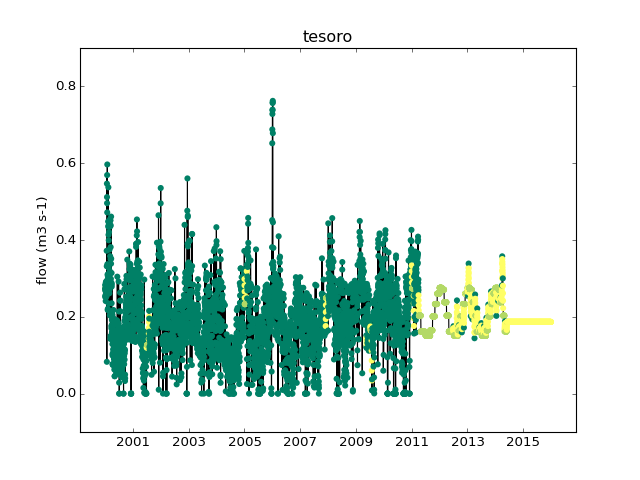

In [50]:
# build up a little dashboard to see what we've got so far:
sites=list(ds.site.values)
plot_vars=[s for s in ds.data_vars if not s.endswith('_flag')]
plot_vars

fig,ax=plt.subplots(1,1)

def update_plot(site,plot_var):    
    ax.cla()
    ax.plot(ds.time,
            ds[plot_var].sel(site=site),'k-')
    ax.scatter(ds.time.values,
               ds[plot_var].sel(site=site).values,30,
               np.log(1+ds[plot_var+'_flag'].sel(site=site).values),
               cmap='summer',
               lw=0,zorder=5)
    ax.set_ylabel("%s (%s)"%(plot_var,ds[plot_var].attrs['units']))
    ax.set_title(site)
    plt.draw()
    
site='ebmud'
plot_var='flow'
update_plot(site='ebmud',plot_var='flow')
gui=interactive(update_plot,site=sites,plot_var=plot_vars)

In [51]:
gui

In [54]:
# Still need lat/lon...
ds.to_netcdf(os.path.join( output_dir,'sfbay_potw.nc'))